In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold

In [70]:
df_train = pd.read_csv("data/houses/kc_house_data.csv")

In [74]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day

df_train.drop(['date'], inplace=True, axis=1)

In [72]:
df_train.drop(["id"], axis=1, inplace=True)

In [77]:
# Select features with absolute Skew higher than 0.5
skew_ft = []

for i in df_train.columns:
    # list of skew for each corresponding feature
    skew_ft.append(abs(df_train[i].skew()))

df_skewed = pd.DataFrame({"Columns": df_train.columns, "Abs_Skew": skew_ft})
sk_features = df_skewed[df_skewed["Abs_Skew"] > 0.5]["Columns"].tolist()

for i in sk_features:
    # loop over i (features) to calculate Log of surfaces
    # Training set
    df_train[i] = np.log((df_train[i])+1)

df_train["price"] = np.log(df_train.price)

c:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [78]:
X = df_train[[i for i in list(
    df_train.columns) if i != "price"]]
print(X.shape)

# Target (y)
y = df_train.loc[:, "price"]
print(y.shape)

(21613, 21)
(21613,)


In [79]:
bins = np.linspace(0, len(y), 150)
y_binned = np.digitize(y, bins)

# Split the data
X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size=0.3,
                                                      stratify=y_binned, shuffle=True)
print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")
print(f"\nX_test:{X_calib.shape}\ny_test:{y_calib.shape}")

X_train:(15129, 21)
y_train:(15129,)

X_test:(6484, 21)
y_test:(6484,)


In [80]:
from sklearn import preprocessing

# Standardize the data
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_calib = std_scale.transform(X_calib)


# The output of standardization is a vector. Let's turn it into a table
# Convert X, y and test data into dataframe
X_train = pd.DataFrame(X_train, columns=X.columns)
X_calib = pd.DataFrame(X_calib, columns=X.columns)

y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index().drop("index", axis=1)

y_calib = pd.DataFrame(y_calib)
y_calib = y_calib.reset_index().drop("index", axis=1)

c:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\utils\extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [81]:
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [82]:
model_xg = XGBRegressor()

In [83]:
from sklearn.metrics import mean_squared_error, r2_score

# Define a function for each metric
# R²
def rsqr_score(test, pred):
    """Calculate R squared score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        R squared score 
    """
    r2_ = r2_score(test, pred)
    return r2_


# RMSE
def rmse_score(test, pred):
    """Calculate Root Mean Square Error score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Root Mean Square Error score
    """
    rmse_ = np.sqrt(mean_squared_error(test, pred))
    return rmse_


# Print the scores
def print_score(test, pred, model):
    """Print calculated score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        print the regressor name
        print the R squared score
        print Root Mean Square Error score
    """

    print(f"**** Regressor: {model} ****")
    print(f"R²: {rsqr_score(test, pred)}")
    print(f"RMSE: {rmse_score(test, pred)}\n")

In [84]:
# Define hyperparameters
tuned_parameters_xgb = {"max_depth": [3],
                        "colsample_bytree": [0.3, 0.7],
                        "learning_rate": [0.01, 0.05, 0.1],
                        "n_estimators": [100, 500, 1000]}

# GridSearch
xgbr_cv = GridSearchCV(estimator=XGBRegressor(),
                       param_grid=tuned_parameters_xgb,
                       cv=5,
                       n_jobs=-1,
                       verbose=1)

# fit the GridSearch on train set
xgbr_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {xgbr_cv.best_params_}\n")
print(f"Best R²: {xgbr_cv.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  8.4min finished


Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}

Best R²: 0.8970645548819369


In [85]:
model_xgb_opt = XGBRegressor(colsample_bytree = xgbr_cv.best_params_["colsample_bytree"],
                             learning_rate = xgbr_cv.best_params_["learning_rate"],
                             max_depth = xgbr_cv.best_params_["max_depth"],
                             n_estimators = xgbr_cv.best_params_["n_estimators"])

model_xgb_opt.fit(X_train, y_train)
y_pred_xgb_opt = model_xgb_opt.predict(X_calib)
print_score(y_calib, y_pred_xgb_opt, "XGBoost")

**** Regressor: XGBoost ****
R²: 0.8992283570720371
RMSE: 0.012577900392982812



### CP6

In [37]:
from data_models.basic import LinearData, LinearDataCorrelated
from conformal_prediction.basic import SplitConformal, QuantileConformal
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib.patches as mpatches
from collections import defaultdict
import statsmodels.formula.api as smf
import aux_funcs
import json
from scipy.stats import foldnorm, norm
from scipy.stats import pearsonr, t

In [38]:
best_params = {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}

In [97]:
B = 100
conformal_type = SplitConformal
alpha = 0.05

boot_size = []
vars_j_1 = []
vars_j_2 = []
vars_LOCO = []
boot_size_1 = defaultdict(list)
boot_size_2 = defaultdict(list)
boot_LOCO = defaultdict(list)

model_full = XGBRegressor(colsample_bytree = best_params["colsample_bytree"],
                          learning_rate = best_params["learning_rate"],
                          max_depth = best_params["max_depth"],
                          n_estimators = best_params["n_estimators"])
model_full.fit(X_train, y_train)
model_full = copy.copy(model_full)

conformal_predictor = conformal_type(alpha=alpha)
size = 2*conformal_predictor.calibrate(data_X=X_calib, data_y=y_calib.iloc[:, 0], 
                                       model=model_full, rand_state=None)

data_X_train = copy.copy(X_train)
data_X_calib = copy.copy(X_calib)
    
for variable in X_calib.columns:

    # Train Twice
    data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
    data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]

    model_j_2 = XGBRegressor(colsample_bytree = best_params["colsample_bytree"],
                          learning_rate = best_params["learning_rate"],
                          max_depth = best_params["max_depth"],
                          n_estimators = best_params["n_estimators"])
    model_j_2.fit(data_X_train_j_2, y_train)

    conformal_predictor_j = SplitConformal(alpha=alpha)

    size_j_2 = 2*conformal_predictor_j.calibrate(data_X=data_X_calib_j_2, data_y=y_calib.iloc[:, 0], 
                                                    model=model_j_2, rand_state=None)
    vars_j_2.append(size_j_2-size)

    # Train Once
    data_X_calib_j_1 = copy.copy(data_X_calib)
    data_X_calib_j_1[variable] = 0

    conformal_predictor_j = SplitConformal(alpha=alpha)

    size_j_1 = 2*conformal_predictor_j.calibrate(data_X=data_X_calib_j_1, data_y=y_calib.iloc[:, 0], 
                                                    model=model_full, rand_state=None)

    vars_j_1.append(size_j_1-size)

    # LOCO
    vars_LOCO.append(np.median(abs(y_calib.iloc[:, 0]-model_j_2.predict(data_X_calib_j_2))-abs(y_calib.iloc[:, 0]-model_full.predict(data_X_calib))))

for i in range(B):

    if i % 50 == 0:
        print(i)

    train_rand = np.random.choice(np.arange(0, len(X_train)), size=len(X_train), replace=True)
    calib_rand = np.random.choice(np.arange(0, len(X_calib)),size=len(X_calib), replace=True)

    train_data_X = copy.copy(X_train.iloc[train_rand])
    train_data_y = copy.copy(y_train.iloc[train_rand])
    calib_data_X = copy.copy(X_calib.iloc[calib_rand])
    calib_data_y = copy.copy(y_calib.iloc[calib_rand])

    model_full = XGBRegressor(colsample_bytree = best_params["colsample_bytree"],
                                learning_rate = best_params["learning_rate"],
                                max_depth = best_params["max_depth"],
                                n_estimators = best_params["n_estimators"])
    model_full.fit(train_data_X, train_data_y)
    model_full = copy.copy(model_full)

    conformal_predictor = conformal_type(alpha=alpha)
    size = 2*conformal_predictor.calibrate(data_X=calib_data_X, data_y=calib_data_y.iloc[:, 0], 
                                                          model=model_full, rand_state=None)

    boot_size.append(size)

    data_X_train = copy.copy(train_data_X)
    data_X_calib = copy.copy(calib_data_X)
    
    for variable in X_calib.columns:

        # Train Twice
        data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
        data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]

        model_j_2 = XGBRegressor(colsample_bytree = best_params["colsample_bytree"],
                          learning_rate = best_params["learning_rate"],
                          max_depth = best_params["max_depth"],
                          n_estimators = best_params["n_estimators"])
        model_j_2.fit(data_X_train_j_2, train_data_y)

        conformal_predictor_j = SplitConformal(alpha=alpha)

        size_j_2 = 2*conformal_predictor_j.calibrate(data_X=data_X_calib_j_2, data_y=calib_data_y.iloc[:, 0], 
                                                     model=model_j_2, rand_state=None)
        boot_size_2[variable].extend([size_j_2])

        # Train Once
        data_X_calib_j_1 = copy.copy(data_X_calib)
        data_X_calib_j_1[variable] = 0  

        conformal_predictor_j = SplitConformal(alpha=alpha)

        size_j_1 = 2*conformal_predictor_j.calibrate(data_X=data_X_calib_j_1, data_y=calib_data_y.iloc[:, 0], 
                                                     model=model_full, rand_state=None)

        boot_size_1[variable].extend([size_j_1])

        # LOCO
        boot_LOCO[variable].extend([np.median(abs(calib_data_y.iloc[:, 0]-model_j_2.predict(data_X_calib_j_2))-abs(calib_data_y.iloc[:, 0]-model_full.predict(data_X_calib)))])

with open('data_results/Houses/boot_xgb_split_size_full.json', 'w') as fp:
    json.dump(boot_size, fp)

with open('data_results/Houses/boot_xgb_split_train_once_size.json', 'w') as fp:
    json.dump(boot_size_1, fp)

with open('data_results/Houses/boot_xgb_split_train_twice_size.json', 'w') as fp:
    json.dump(boot_size_2, fp)

with open('data_results/Houses/boot_xgb_split_train_LOCO.json', 'w') as fp:
    json.dump(boot_LOCO, fp)

with open('data_results/Houses/xgb_split_train_LOCO.json', 'w') as fp:
    json.dump(vars_LOCO, fp)

with open('data_results/Houses/boot_xgb_split_train_twice_var_1_j.json', 'w') as fp:
    json.dump(vars_j_1, fp)

with open('data_results/Houses/boot_xgb_split_train_twice_var_2_j.json', 'w') as fp:
    json.dump(vars_j_2, fp)

0
50


In [98]:
import scipy
from matplotlib.transforms import Affine2D
from mpl_axes_aligner import align

yerr_1 = []
yerr_2 = []
yerr_LOCO = []

for i, variable in enumerate(X_calib.columns):

    data_1 = np.array(boot_size_1[variable]) - np.array(boot_size)
    data_2 = np.array(boot_size_2[variable]) - np.array(boot_size)

    std_1 = np.std(data_1, ddof=1)
    std_2 = np.std(data_2, ddof=1)
    std_LOCO = np.std(boot_LOCO[variable], ddof=1)
    h_1 = scipy.stats.norm.ppf(1-0.05/2)*std_1
    yerr_1.append(h_1)
    h_2 = scipy.stats.norm.ppf(1-0.05/2)*std_2
    yerr_2.append(h_2)
    h_LOCO = scipy.stats.norm.ppf(1-0.05/2)*std_LOCO
    yerr_LOCO.append(h_LOCO)

c:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


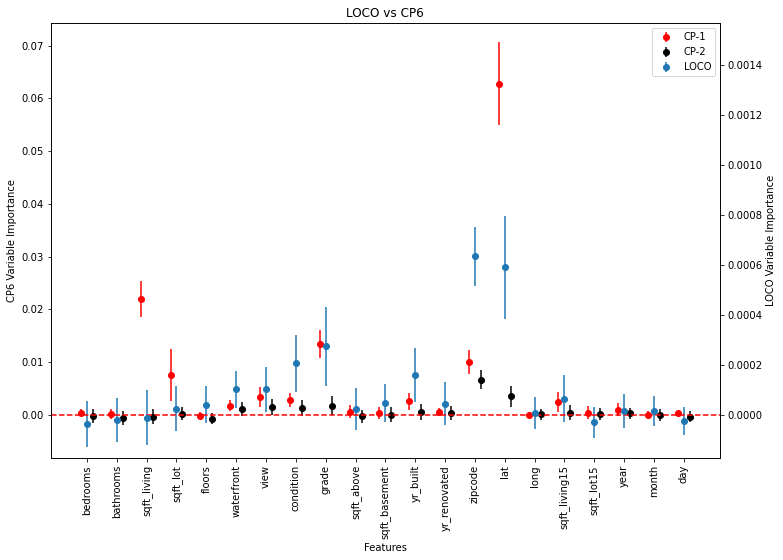

In [106]:
x = X_calib.columns

fig, ax1 = plt.subplots(figsize=(12,8))

trans1 = Affine2D().translate(-0.2, 0.0) + ax1.transData
trans2 = Affine2D().translate(+0.2, 0.0) + ax1.transData
ax1.set_xlabel('Features')
ax1.set_ylabel('CP6 Variable Importance')
p1 = ax1.errorbar(x, vars_j_1, yerr=yerr_1, fmt='o', transform=trans1, color='red', label='CP-1')
p2 = ax1.errorbar(x, vars_j_2, yerr=yerr_2, fmt='o', transform=trans2, color='black', label='CP-2')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('LOCO Variable Importance') 
p3 = ax2.errorbar(x, vars_LOCO, yerr=yerr_LOCO, fmt='o', label='LOCO')
plt.axline(xy1=(0, 0), slope=0, color='r', linestyle='--')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title('LOCO vs CP6')

# Adjust the plotting range of two y axes
org1 = 0.0  # Origin of first axis
org2 = 0.0  # Origin of second axis
pos = 0.1  # Position the two origins are aligned
align.yaxes(ax1, org1, ax2, org2, pos)
ax1.set_xticklabels(labels=x, rotation=90)

plt.savefig('images/Houses/LOCO_vs_CP6_new')
plt.show()